In [1]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier


In [2]:
from google.colab import files
uploaded = files.upload()

file_name = "train_titanic.csv"
train_titanic_data = pd.read_csv(file_name)

print(train_titanic_data.head())
print(train_titanic_data.info())


Saving train_titanic.csv to train_titanic.csv
   PassengerId  pclass  survived  \
0         1000       3         1   
1          393       2         1   
2          629       3         0   
3         1166       3         0   
4          605       3         1   

                                            name     sex   age  sibsp  parch  \
0              McCarthy, Miss. Catherine "Katie"  female   NaN      0      0   
1  del Carlo, Mrs. Sebastiano (Argenia Genovesi)  female  24.0      1      0   
2              Andersson, Miss. Sigrid Elisabeth  female  11.0      4      2   
3                               Saad, Mr. Khalil    male  25.0      0      0   
4                    Abelseth, Miss. Karen Marie  female  16.0      0      0   

          ticket     fare cabin embarked   boat  body  \
0         383123   7.7500   NaN        Q  15 16   NaN   
1  SC/PARIS 2167  27.7208   NaN        C     12   NaN   
2         347082  31.2750   NaN        S    NaN   NaN   
3           2672   7.2250   

In [3]:
uploaded = files.upload()

file_name = "test_titanic.csv"
test_data = pd.read_csv(file_name)

Saving test_titanic.csv to test_titanic.csv


In [4]:
data = [train_titanic_data, test_data]


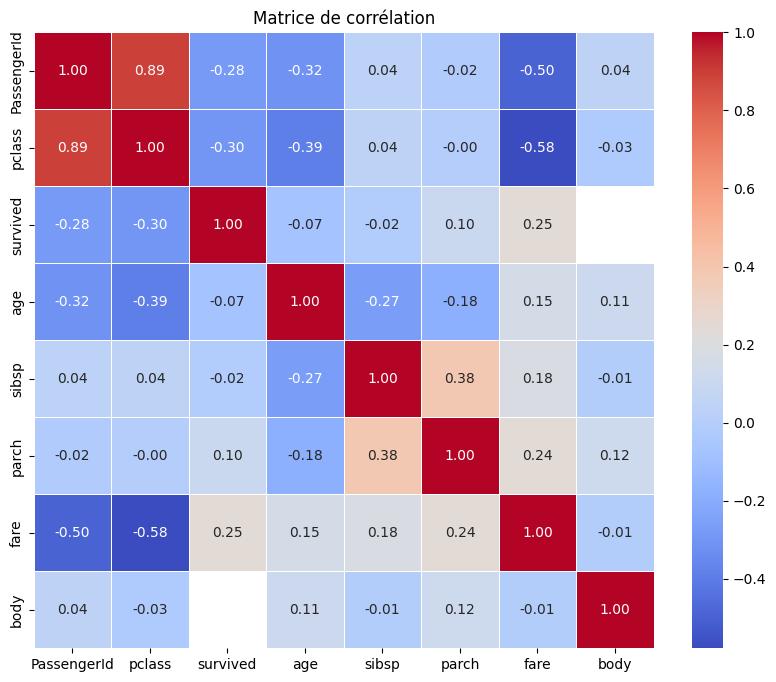

In [5]:
numeric_columns = train_titanic_data.select_dtypes(include=['number'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation")
plt.show()

In [6]:
train_titanic_data = train_titanic_data.drop(['ticket', 'cabin', 'body', 'home.dest', 'boat'], axis=1)
test_data = test_data.drop(['ticket', 'cabin', 'body', 'home.dest', 'boat'], axis=1)
data = [train_titanic_data, test_data]

In [7]:
for dataset in data:
    dataset['title'] = dataset.name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_titanic_data['title'], train_titanic_data['sex'])

sex,female,male
title,,
Capt,0,1
Col,0,3
Countess,1,0
Don,0,1
Dona,1,0
Dr,0,6
Major,0,1
Master,0,51
Miss,210,0


In [8]:
for dataset in data:
    dataset['title'] = dataset['title'].replace(['Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Dona'], 'Rare')

    dataset['title'] = dataset['title'].replace('Mlle', 'Miss')
    dataset['title'] = dataset['title'].replace('Ms', 'Miss')
    dataset['title'] = dataset['title'].replace('Mme', 'Mrs')

train_titanic_data[['title', 'survived']].groupby(['title'], as_index=False).mean()

,title,survived
0,Master,0.490196
1,Miss,0.668224
2,Mr,0.169967
3,Mrs,0.788462
4,Rare,0.300000


In [9]:
title_order = {"Mr": 1, "Master": 2, "Miss": 3, "Mrs": 4, "Rare": 5}

for dataset in data:
    dataset['title'] = dataset['title'].map(title_order)
    dataset['title'] = dataset['title'].fillna(0)


In [10]:
train_titanic_data = train_titanic_data.drop(['name', 'PassengerId'], axis=1)
test_data = test_data.drop(['name'], axis=1)
data = [train_titanic_data, test_data]


In [11]:
for dataset in data:
    dataset['sex'] = dataset['sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_titanic_data.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title
0,3,1,1,NaN,0,0,7.7500,Q,3
1,2,1,1,24.0,1,0,27.7208,C,4
2,3,0,1,11.0,4,2,31.2750,S,3
3,3,0,0,25.0,0,0,7.2250,C,1
4,3,1,1,16.0,0,0,7.6500,S,3


In [12]:
for dataset in data:
    print(dataset.columns)

Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'title'],
      dtype='object')
Index(['PassengerId', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'title'],
      dtype='object')


In [13]:
print(train_titanic_data.isnull().sum())

pclass        0
survived      0
sex           0
age         209
sibsp         0
parch         0
fare          1
embarked      0
title         0
dtype: int64


In [14]:
print(test_data.isnull().sum())

PassengerId     0
pclass          0
sex             0
age            54
sibsp           0
parch           0
fare            0
embarked        2
title           0
dtype: int64


In [15]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Sélection des caractéristiques et de la cible
features = ['pclass', 'sex', 'sibsp', 'parch', 'fare', 'embarked', 'title']
X = train_titanic_data[features]
y = train_titanic_data['age']

# Remplir les valeurs manquantes de 'embarked' avant l'encodage
X.loc[:, 'embarked'] = X['embarked'].fillna(X['embarked'].mode()[0])

# Mapper les valeurs de 'embarked' en 1, 2, 3
embarked_mapping = {'S': 1, 'C': 2, 'Q': 3}
X.loc[:, 'embarked'] = X['embarked'].map(embarked_mapping)



# Définir le préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['pclass', 'sibsp', 'parch', 'fare']),
        ('cat', 'passthrough', ['sex', 'embarked', 'title']),
    ],
    remainder='passthrough'
)

# Transformation des données
X_transformed = preprocessor.fit_transform(X)

# Vérification des valeurs manquantes dans 'age' avant l'imputation
print("Nombre de valeurs manquantes dans 'age' avant imputation :")
print(y.isnull().sum())

# Si des valeurs manquantes existent dans 'age', procéder à l'imputation
if y.isnull().sum() > 0:
    # Séparer les données avec et sans âge pour l'entraînement
    X_train = X_transformed[~y.isnull()]
    y_train = y.dropna()
    X_to_predict = X_transformed[y.isnull()]

    # Optimisation des hyperparamètres et entraînement du modèle
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 7],
        'l2_regularization': [0, 0.1, 1]
    }

    model = HistGradientBoostingRegressor(random_state=0)
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Meilleurs hyperparamètres :", grid_search.best_params_)
    print("Meilleur score (MSE négatif) :", grid_search.best_score_)

    best_model = grid_search.best_estimator_

    # Prédiction des âges manquants
    predicted_ages = best_model.predict(X_to_predict)

    train_titanic_data.loc[train_titanic_data['age'].isnull(), 'age'] = predicted_ages
else:
    print("Il n'y a pas de valeurs manquantes dans 'age'.")

print("\nNombre de valeurs manquantes après imputation :")
print(train_titanic_data.isnull().sum())

print("\nPremières lignes du DataFrame avec les âges imputés :")
print(train_titanic_data.head())

train_titanic_data['age'] = train_titanic_data['age'].astype(int)
print("\nNombre de valeurs manquantes après imputation et conversion en int :")
print(train_titanic_data.isnull().sum())
print("\nPremières lignes du DataFrame avec les âges imputés et convertis en int:")
print(train_titanic_data.head())


Nombre de valeurs manquantes dans 'age' avant imputation :
209
Meilleurs hyperparamètres : {'l2_regularization': 1, 'learning_rate': 0.1, 'max_depth': 3}
Meilleur score (MSE négatif) : -120.0621605715788

Nombre de valeurs manquantes après imputation :
pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        1
embarked    0
title       0
dtype: int64

Premières lignes du DataFrame avec les âges imputés :
   pclass  survived  sex       age  sibsp  parch     fare embarked  title
0       3         1    1  26.21639      0      0   7.7500        Q      3
1       2         1    1  24.00000      1      0  27.7208        C      4
2       3         0    1  11.00000      4      2  31.2750        S      3
3       3         0    0  25.00000      0      0   7.2250        C      1
4       3         1    1  16.00000      0      0   7.6500        S      3

Nombre de valeurs manquantes après imputation et conversion en int :
pclass      0
survived    0
sex        

In [16]:
print(train_titanic_data.isnull().sum())

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        1
embarked    0
title       0
dtype: int64


In [17]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Sélection des caractéristiques et de la cible
features = ['pclass', 'sex', 'sibsp', 'parch', 'fare', 'embarked', 'title']
X = test_data[features]
y = test_data['age']

# Remplir les valeurs manquantes de 'embarked' avant l'encodage
X.loc[:, 'embarked'] = X['embarked'].fillna(X['embarked'].mode()[0])

# Mapper les valeurs de 'embarked' en 1, 2, 3
embarked_mapping = {'S': 1, 'C': 2, 'Q': 3}
X.loc[:, 'embarked'] = X['embarked'].map(embarked_mapping)




preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['pclass', 'sibsp', 'parch', 'fare']),
    ],
    remainder='passthrough'
)

X_transformed = preprocessor.fit_transform(X)

print("Nombre de valeurs manquantes dans 'age' avant imputation :")
print(y.isnull().sum())

# Si des valeurs manquantes existent dans 'age', procéder à l'imputation
if y.isnull().sum() > 0:
    # Séparer les données avec et sans âge pour l'entraînement
    X_train = X_transformed[~y.isnull()]
    y_train = y.dropna()
    X_to_predict = X_transformed[y.isnull()]

    # Optimisation des hyperparamètres et entraînement du modèle
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 7],
        'l2_regularization': [0, 0.1, 1]
    }

    model = HistGradientBoostingRegressor(random_state=0)
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Affichage des meilleurs hyperparamètres et score
    print("Meilleurs hyperparamètres :", grid_search.best_params_)
    print("Meilleur score (MSE négatif) :", grid_search.best_score_)

    best_model = grid_search.best_estimator_

    # Prédiction des âges manquants
    predicted_ages = best_model.predict(X_to_predict)

    test_data.loc[test_data['age'].isnull(), 'age'] = predicted_ages
else:
    print("Il n'y a pas de valeurs manquantes dans 'age'.")

print("\nNombre de valeurs manquantes après imputation :")
print(test_data.isnull().sum())

print("\nPremières lignes du DataFrame avec les âges imputés :")
print(test_data.head())

print("\nNombre de valeurs manquantes après imputation et conversion en int :")
print(test_data.isnull().sum())
print("\nPremières lignes du DataFrame avec les âges imputés et convertis en int:")
print(test_data.head())


Nombre de valeurs manquantes dans 'age' avant imputation :
54
Meilleurs hyperparamètres : {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_depth': 3}
Meilleur score (MSE négatif) : -127.57033065067526

Nombre de valeurs manquantes après imputation :
PassengerId    0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       2
title          0
dtype: int64

Premières lignes du DataFrame avec les âges imputés :
   PassengerId  pclass  sex        age  sibsp  parch     fare embarked  title
0         1029       3    1  17.351219      1      0  24.1500        Q    3.0
1         1122       3    0   4.280624      1      1  22.3583        C    2.0
2         1156       3    0  26.314705      0      0   7.7750        S    1.0
3         1252       3    0  30.500000      0      0   8.0500        S    1.0
4          722       3    0  36.000000      0      0   7.4958        S    1.0

Nombre de valeurs manquantes après imputation et conver

In [18]:
print(test_data.isnull().sum())


PassengerId    0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       2
title          0
dtype: int64


In [19]:
train_titanic_data['ageIntervalle'] = pd.cut(train_titanic_data['age'], 5)
train_titanic_data[['ageIntervalle', 'survived']].groupby(['ageIntervalle'], as_index=False).mean().sort_values(by='ageIntervalle', ascending=True)

<ipython-input-19-a95e10fea1aa>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_titanic_data[['ageIntervalle', 'survived']].groupby(['ageIntervalle'], as_index=False).mean().sort_values(by='ageIntervalle', ascending=True)


,ageIntervalle,survived
0,"(-0.08, 16.0]",0.516129
1,"(16.0, 32.0]",0.354724
2,"(32.0, 48.0]",0.378676
3,"(48.0, 64.0]",0.405063
4,"(64.0, 80.0]",0.181818


In [20]:
for dataset in data:
    dataset.loc[ dataset['age'] <= 16, 'age'] = 0
    dataset.loc[(dataset['age'] > 16) & (dataset['age'] <= 32), 'age'] = 1
    dataset.loc[(dataset['age'] > 32) & (dataset['age'] <= 48), 'age'] = 2
    dataset.loc[(dataset['age'] > 48) & (dataset['age'] <= 64), 'age'] = 3
    dataset.loc[(dataset['age'] > 64) & (dataset['age'] <= 80), 'age'] = 4

train_titanic_data.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title,ageIntervalle
0,3,1,1,1,0,0,7.7500,Q,3,"(16.0, 32.0]"
1,2,1,1,1,1,0,27.7208,C,4,"(16.0, 32.0]"
2,3,0,1,0,4,2,31.2750,S,3,"(-0.08, 16.0]"
3,3,0,0,1,0,0,7.2250,C,1,"(16.0, 32.0]"
4,3,1,1,0,0,0,7.6500,S,3,"(-0.08, 16.0]"


In [21]:
train_titanic_data = train_titanic_data.drop(['ageIntervalle'], axis=1)
data = [train_titanic_data, test_data, test_data]


In [22]:
train_titanic_data['familySize'] = train_titanic_data['sibsp'] + train_titanic_data['parch'] + 1
test_data['familySize'] = test_data['sibsp'] + test_data['parch'] + 1
data = [train_titanic_data, test_data]
train_titanic_data.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title,familySize
0,3,1,1,1,0,0,7.7500,Q,3,1
1,2,1,1,1,1,0,27.7208,C,4,2
2,3,0,1,0,4,2,31.2750,S,3,7
3,3,0,0,1,0,0,7.2250,C,1,1
4,3,1,1,0,0,0,7.6500,S,3,1


In [23]:
train_titanic_data = train_titanic_data.drop(['sibsp', 'parch'], axis=1)
test_data = test_data.drop(['sibsp', 'parch'], axis=1)
data = [train_titanic_data, test_data]


In [24]:
print(test_data.isnull().sum())


PassengerId    0
pclass         0
sex            0
age            0
fare           0
embarked       2
title          0
familySize     0
dtype: int64


In [25]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['pclass', 'sex', 'familySize', 'age']
target = 'fare'

titanic_data_missing_fare = train_titanic_data[train_titanic_data['fare'].isnull()]
titanic_data_non_missing_fare = train_titanic_data.dropna(subset=['fare'])

X_train = titanic_data_non_missing_fare[features]
y_train = titanic_data_non_missing_fare[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Modèle de régression HistGradientBoosting
model = HistGradientBoostingRegressor()
model.fit(X_train_scaled, y_train)

X_missing_fare = titanic_data_missing_fare[features]
X_missing_fare_scaled = scaler.transform(X_missing_fare)

predicted_fares = model.predict(X_missing_fare_scaled)

# Remplacer les valeurs manquantes de 'Fare' par les prédictions
train_titanic_data.loc[train_titanic_data['fare'].isnull(), 'fare'] = predicted_fares

print(train_titanic_data.isnull().sum())


pclass        0
survived      0
sex           0
age           0
fare          0
embarked      0
title         0
familySize    0
dtype: int64


In [33]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['pclass', 'sex', 'familySize', 'age']
target = 'fare'

test_data_missing_fare = test_data[test_data['fare'].isnull()]
test_data_non_missing_fare = test_data.dropna(subset=['fare'])

X_train = test_data_non_missing_fare[features]
y_train = test_data_non_missing_fare[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Modèle de régression HistGradientBoosting
model = HistGradientBoostingRegressor()
model.fit(X_train_scaled, y_train)

X_missing_fare = test_data_missing_fare[features]

predicted_fares = model.predict(X_missing_fare_scaled)

# Remplacer les valeurs manquantes de 'Fare' par les prédictions
test_data.loc[test_data['fare'].isnull(), 'fare'] = predicted_fares

print(test_data.isnull().sum())


PassengerId    0
pclass         0
sex            0
age            0
fare           0
embarked       2
title          0
familySize     0
dtype: int64


In [34]:
test_data.loc[:, 'embarked'] = test_data['embarked'].fillna(test_data['embarked'].mode()[0])


In [35]:
print(test_data.isnull().sum())


PassengerId    0
pclass         0
sex            0
age            0
fare           0
embarked       0
title          0
familySize     0
dtype: int64


In [36]:

for dataset in data:
    dataset['embarked'] = dataset['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [37]:
print(test_data.isnull().sum())


PassengerId    0
pclass         0
sex            0
age            0
fare           0
embarked       0
title          0
familySize     0
dtype: int64


In [38]:
print(train_titanic_data.isnull().sum())


pclass        0
survived      0
sex           0
age           0
fare          0
embarked      0
title         0
familySize    0
dtype: int64


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier

X = train_titanic_data.drop("survived", axis=1)
Y = train_titanic_data["survived"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

model = HistGradientBoostingClassifier()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy of HistGradientBoostingClassifier: {accuracy*100:.2f}")


X_train shape: (837, 7)
Y_train shape: (837,)
X_test shape: (210, 7)
Y_test shape: (210,)
Accuracy of HistGradientBoostingClassifier: 77.14


In [27]:
X_test_final  = test_data.drop("PassengerId", axis=1).copy()
X_test_final.shape

(262, 7)

In [42]:
# Entraînement du modèle Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

train_accuracy = random_forest.score(X_train, Y_train)
acc_train = round(train_accuracy * 100, 2)

test_accuracy = random_forest.score(X_test, Y_test)
acc_test = round(test_accuracy * 100, 2)

print(f"Accuracy on training set: {acc_train}%")
print(f"Accuracy on test set: {acc_test}%")

Accuracy on training set: 93.19%
Accuracy on test set: 76.19%


In [43]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

X = train_titanic_data.drop("survived", axis=1)
Y = train_titanic_data["survived"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

xgboost_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgboost_model.fit(X_train, Y_train)

Y_pred = xgboost_model.predict(X_test)

acc_xgboost = accuracy_score(Y_test, Y_pred) * 100

print(f"Accuracy on test set: {round(acc_xgboost, 2)}%")


X_train shape: (837, 7)
Y_train shape: (837,)
X_test shape: (210, 7)
Y_test shape: (210,)
Accuracy on test set: 78.1%


In [44]:
X_test_final = test_data.drop("PassengerId", axis=1)
X_test_final.shape
xgboost_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgboost_model.fit(X_train, Y_train)

Y_pred = xgboost_model.predict(X_test_final)

In [46]:
from sklearn.neural_network import MLPClassifier

# Entraîner un réseau de neurones
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
nn_model.fit(X_train, Y_train)

Y_pred = nn_model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy : {accuracy*100:.2f}")

Accuracy : 80.00


In [47]:
Y_pred = nn_model.predict(X_test_final)

In [49]:
from sklearn.svm import SVC

# Entraîner un modèle SVC
svm_model = SVC(kernel='rbf', C=1, gamma='auto')
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy : {accuracy*100:.2f}")

Accuracy : 77.14


In [50]:
Y_pred = svm_model.predict(X_test_final)


In [54]:
if len(test_data) != len(Y_pred):
    print("Error: Prediction and Passenger ID lengths don't match!")
else:
    submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "survived": Y_pred.astype(int)
    })

In [55]:
submission.to_csv('submission.csv', index=False)

print("Le fichier submission.csv a été créé avec succès.")

Le fichier submission.csv a été créé avec succès.
